##### Imports

In [22]:
import sys, os
from asvFormula.digraph import *
from asvFormula.classesSizes.algorithmTime import measureGraphTime
from asvFormula.bayesianNetworks.bayesianNetwork import *
from asvFormula.bayesianNetworks import *
from asvFormula.topoSorts import allForestTopoSorts
from pgmpy.readwrite import BIFReader
import pandas as pd
import seaborn as sns
import timeit
import itertools

# Experimentation

## Generating the results

In [19]:
resultsFolder = 'results/graphData/'

naiveBayesWithPathFile = resultsFolder + 'naiveBayes.csv'
multiplePathsFile = resultsFolder + 'multiplePaths.csv'
balancedTreesFile = resultsFolder + 'balancedTrees.csv'
childNetworkFile = resultsFolder + 'childNetwork.csv'

childNetworkPath = networkSamplesPath + "/child.bif"

### Auxiliary Functions

In [ ]:
printEnabled = True
def disablePrint():
    global printEnabled
    if printEnabled:
        sys._jupyter_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')
        printEnabled = False

def enablePrint():
    global printEnabled
    printEnabled = True
    sys.stdout.close()
    sys.stdout = sys._jupyter_stdout

def convertDictToCsv(dict, filename, orient='index', sortByColumn = None):

    df = pd.DataFrame.from_dict(dict, orient=orient)

    if sortByColumn is not None:
        df = df.sort_values(by=sortByColumn)
    # Save the DataFrame to a CSV file
    df.to_csv(filename)

def dataframeFromCsv(filename : str):
    df = pd.read_csv(filename, index_col=0)
    df.name = filename.split('/')[-1][:-4]
    return df

def convertCsvToDict(filename):
    df = dataframeFromCsv(filename)
    return df.to_dict()

### Time Naive Bayes

In [ ]:
def timeMultipleNaiveBayesWithPath(numNodes, pathLength, startFrom = 1):
    graphsResults = {}
    for i in range(startFrom,numNodes+1):
        for j in range(startFrom,pathLength+1):
            graphToEvaluate = naiveBayesWithPath(i, j)
            nodesToEvaluate = list(range(i+j-8, i+j))
            print(f'{i} Children, {j} PathLength' + str(nodesToEvaluate))
            graphsResults[f'{i} Children, {j} PathLength'] = measureGraphTime(graphToEvaluate, nodesToEvaluate)
            convertDictToCsv(graphsResults, naiveBayesWithPathFile)
    return graphsResults
    

numNodes = 20
pathLenght = 20
resNaiveBayes = timeMultipleNaiveBayesWithPath(numNodes, pathLenght,10)

### Time multiple Paths

In [ ]:
def timeMultiplePathsGraphs(numPaths, pathLength, startFrom = 1):
    graphsResults = {}
    for i in range(startFrom,numPaths+1):
        for j in range(startFrom,pathLength+1):
            graphToEvaluate = multiplePaths(i, j)
            #drawGraph(graphToEvaluate)
            nodesToEvaluate = list(range(0, j))
            print(f'{i} Paths, {j} Length' + str(nodesToEvaluate))
            graphsResults[f'{i} Paths, {j} Length'] = measureGraphTime(graphToEvaluate, nodesToEvaluate)
            convertDictToCsv(graphsResults, multiplePathsFile)

    return graphsResults
    

numberOfPaths = 8
pathLenght = 8
resMultiplePaths = timeMultiplePathsGraphs(numberOfPaths, pathLenght,4)

### Time balanced trees

In [ ]:
def timeMultipleBalancedTrees(numLevels, branchingFactor = 2, startLevels = 1, starBranching = 2):
    graphsResults = {}
    for i in range(startLevels,numLevels+1):
        for j in range(starBranching,branchingFactor+1):
            graphToEvaluate = balancedTree(i, j)
            #drawGraph(graphToEvaluate)
            leafNode = [node for node in graphToEvaluate.nodes if isLeaf(node, graphToEvaluate)][0]
            pathToLeaf = orderedNodes(graphToEvaluate, nx.ancestors(graphToEvaluate, leafNode)) + [leafNode]
            print(f'{i} Levels, {j} Branching' + str(pathToLeaf))
            graphsResults[f'{i} Levels, {j} Branching'] = measureGraphTime(graphToEvaluate, pathToLeaf)
            convertDictToCsv(graphsResults, balancedTreesFile)
            

    return graphsResults

numLevels = 6
branchingFactor = 2

resBalancedTrees = timeMultipleBalancedTrees(numLevels, branchingFactor, 2, 2)


### Time child bayesian network

In [ ]:
def timeChildBayesianNetworks():
    graphsResults = {}
    childBayesianNetwork = childBNAsTree(BIFReader(childNetworkPath).get_model())
    childGraph = bayesianNetworkToDigraph(childBayesianNetwork)
    nodesToEvaluate = list(childBayesianNetwork.nodes)
    graphsResults['Child result'] = measureGraphTime(childGraph, nodesToEvaluate)
    convertDictToCsv(graphsResults, childNetworkFile)
            
    return graphsResults

resBalancedTrees = timeChildBayesianNetworks()

### Adding node count and estimated toposort time to the results

In [ ]:
naiveBayesDict = convertCsvToDict(naiveBayesWithPathFile)
multiplePathsDict = convertCsvToDict(multiplePathsFile)
balancedTreesDict = convertCsvToDict(balancedTreesFile)
childDict = convertCsvToDict(childNetworkFile)

nodesColumn = 'Nodes number'
toposTimeColumn = 'Toposorts estimated time'

def addNewColumnToDict(graphDict : Dict, graphKey, newColumn, columnValue):
    if graphKey in graphDict['allTopoSortsNumber'].keys():
        nodesDict = graphDict.get(newColumn, {})
        nodesDict[graphKey] = columnValue
        graphDict[newColumn] = nodesDict

def addNodeCountToDict(graphDict : Dict, graphKey, graph):
      addNewColumnToDict(graphDict, graphKey, nodesColumn, len(graph.nodes))

def addTimeToDict(graphDict : Dict, graphKey, graph):
        toposNumber = 1000
        thousandToposTime = timeit.timeit(lambda : list(itertools.islice(nx.all_topological_sorts(graph), toposNumber)), number=1)
        addNewColumnToDict(graphDict, graphKey, toposTimeColumn, allForestTopoSorts(graph)/toposNumber*thousandToposTime)

def addNodeAndToposTimeToDict(naiveBayesDict,graphKey, naiveBayesGraph):
    addNodeCountToDict(naiveBayesDict, graphKey, naiveBayesGraph)
    addTimeToDict(naiveBayesDict, graphKey, naiveBayesGraph)

def addNodeAndTimeCount(naiveBayesDict, multiplePathsDict, balancedTreesDict):
    for i in range(1,21):
        for j in range(1,21):
                naiveBayesGraph = naiveBayesWithPath(i, j)

                addNodeAndToposTimeToDict(naiveBayesDict, f'{i} Children, {j} PathLength', naiveBayesGraph)
                if i < 7 and j < 3:
                        balancedTreeGraph = balancedTree(i, j)
                        addNodeAndToposTimeToDict(balancedTreesDict, f'{i} Levels, {j} Branching', balancedTreeGraph)
                if i < 9 and j < 9:
                        multiplePathsGraph = multiplePaths(i, j)
                        addNodeAndToposTimeToDict(multiplePathsDict, f'{i} Paths, {j} Length', multiplePathsGraph)
        convertDictToCsv(naiveBayesDict, naiveBayesWithPathFile, 'columns', nodesColumn)
        convertDictToCsv(multiplePathsDict, multiplePathsFile, 'columns', nodesColumn)
        convertDictToCsv(balancedTreesDict, balancedTreesFile, 'columns', nodesColumn)
        convertDictToCsv(childDict, childNetworkFile, 'columns', nodesColumn)

addNodeAndTimeCount(naiveBayesDict, multiplePathsDict, balancedTreesDict)
addTimeToDict(childDict, 'Child result', childBNAsTree(BIFReader(childNetworkPath).get_model()))

## Plotting the results 

In [ ]:
plotsResultsFolder = 'results/plots/'

naiveBayesDf = dataframeFromCsv(naiveBayesWithPathFile)
dfMultiplePaths = dataframeFromCsv(multiplePathsFile)
dfBalancedTrees = dataframeFromCsv(balancedTreesFile)
dfChildNetwork = dataframeFromCsv(childNetworkFile)

filteredDataframes = [naiveBayesDf, dfMultiplePaths, dfBalancedTrees, dfChildNetwork]

for column in ['allTopoSortsNumber', 'biggestEquivClasses', 'smallestEquivClasses']:
    for dataframe in filteredDataframes:
        dataframe[column] = pd.to_numeric(dataframe[column], errors='coerce')

### Equivalence classes vs topological sorts number

In [ ]:
sns.set_theme(style="whitegrid")

plt.figure(figsize=(10, 6))
palette = sns.color_palette("tab10", n_colors=len(filteredDataframes))

# Plot each dataframe separately
for i, df in enumerate(filteredDataframes):
    sns.lineplot(data=df, x="Nodes number", y="allTopoSortsNumber", label=f"Topological Sorts ({df.name})", color=palette[i], errorbar=None)
    sns.lineplot(data=df, x="Nodes number", y="averageEquivClasses", label=f"Avg. Equiv. Classes ({df.name})", linestyle="dotted", color=palette[i], errorbar=None)

plt.yscale("log")

# Labels and title
plt.xlabel("Nodes")
plt.ylabel("Values")
plt.title("Comparison of Average Equivalent Classes and Topological Sorts")

# Show the plot
plt.legend()
plt.savefig(plotsResultsFolder + 'equivalentClassesVsToposorts.png')

### Equivalence classes vs topological sorts time

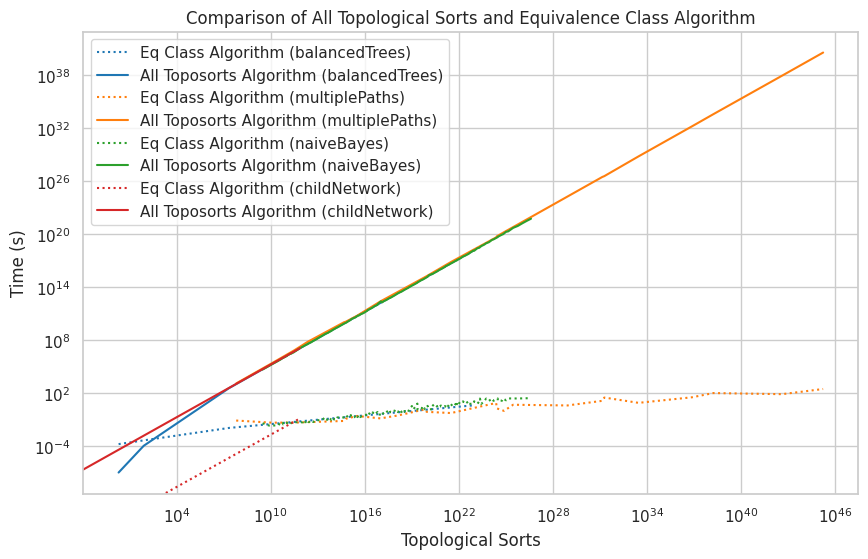

In [ ]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))

filteredDataframes = [dfBalancedTrees, dfMultiplePaths, naiveBayesDf, dfChildNetwork]
for df in filteredDataframes:
    df.dropna(inplace=True,subset=["recursiveAverageTime"])  #Remove the rows where recursiveAverageTime is NaN
palette = sns.color_palette("tab10", n_colors=len(filteredDataframes))


# Plot each dataframe separately
for i, df in enumerate(filteredDataframes):
    sns.lineplot(data=df, x="allTopoSortsNumber", y="recursiveAverageTime", label=f"Eq Class Algorithm ({df.name})", color=palette[i], errorbar=None, linestyle="dotted")
    sns.lineplot(data=df, x="allTopoSortsNumber", y="Toposorts estimated time", label=f"All Toposorts Algorithm ({df.name})", color=palette[i], errorbar=None)

plt.xscale("log")
plt.yscale("log")

# Labels and title
plt.xlabel("Topological Sorts")
plt.ylabel("Time (s)")
plt.title("Comparison of All Topological Sorts and Equivalence Class Algorithm")

# Show the plot
plt.legend()
plt.savefig(plotsResultsFolder + 'equivalentClassesVsAllToposorts_time.png')



### Other plotting

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plotColumns(column1, column2, df, logScale = False):
    sns.set_theme(style='whitegrid')

    plt.figure(figsize=(10, 6))  # Set the figure size
    ax = sns.lineplot(x=column1, y=column2, data=df)

    if logScale:
        ax.set(xscale="log")
        # Define evenly spaced ticks for the x-axis
        min_tick = np.floor(np.log10(naiveBayesDf['allTopoSortsNumber'].min()))
        max_tick = np.ceil(np.log10(naiveBayesDf['allTopoSortsNumber'].max()))
        ticks = np.logspace(min_tick, max_tick, num=5)
        ax.set_xticks(ticks)

    ax.set_xlabel(column1)
    ax.set_ylabel(column2)
    ax.set_title(f'{column1} vs {column2}')

    plt.savefig(f'{plotsResultsFolder}{df.name}-{column1} vs {column2}.png')
    plt.close()
    
    #plt.show()

def plotGraphFamiliy(graphFamiliyData):
    plotColumns('allTopoSortsNumber', 'recursiveAverageTime', graphFamiliyData, True)
    plotColumns('averageEquivClasses', 'recursiveAverageTime', graphFamiliyData)
    plotColumns('averageEquivClasses', 'allTopoSortsNumber', graphFamiliyData)

In [13]:
plotGraphFamiliy(naiveBayesDf)
plotGraphFamiliy(dfMultiplePaths)
plotGraphFamiliy(dfBalancedTrees)

### Optimization experiment

In [ ]:
from asvFormula.digraph import *
from asvFormula.classesSizes import equivalanceClassesSizesWithHashes


graphExample = multiplePaths(3,3)

for node in graphExample.nodes:
    classes = equivalanceClassesSizesWithHashes(graphExample, node)
    print(node)
